# Gamma-ray absorption

#### By: Pablo Sotomayor
---

The production of electron-positron pairs by annihilation of two photons

$$\gamma + \gamma \rightarrow e^+ + e^-$$

plays a double role: it is a source of secondary pairs and a mechanism of photon absorption. This process is possible only above the kinematic energy threshold

$$\epsilon E_{\gamma} (1 - \cos \theta) \geq 2m_{e}^2 c^4$$

where $E_{\gamma}$ and $\epsilon$ are the energies of the photons, and $\theta$ is the collission angle in the observer frame. The annihilation cross section is

$$\sigma_{\gamma \gamma}(\beta) = \frac{3}{16}\sigma_{\rm T}\left(1 - \beta^2 \right) \left[\left(3 - \beta^4 \right) \ln \left(\frac{1 + \beta}{1 - \beta} \right) - 2\beta \left(2 - \beta^2 \right) \right]$$

Here $\beta = \left(1 - \gamma_{e}^{-2} \right)^{1/2}$ and $\gamma_{e}$ is the Lorentz factor of the electron (positron) in the center of momentum frame. It is related to the energy of the photons and the collision angle as

$$\left(1 - \beta^2 \right) = \frac{2m_{e}^2 c^4}{\left(1 - \cos \theta \right)\epsilon E_{\gamma}} \qquad 0 \leq \beta < 1$$

We define the optical depth $\tau_{\gamma \gamma}(E_{\gamma}, R)$ as the probability that a photon of energy $E_{\gamma}$ annihilates against another photon of the target radiation field $n_{\rm ph}(\epsilon, \vec{r})$, after traversing a distance $R$. It is given by:

$$\tau_{\gamma \gamma}(E_{\gamma}, R) = \frac{1}{2}\int_{0}^{R}{\rm d} \ell \int_{\epsilon_{\rm thr}}^{\infty}{\rm d}\epsilon \int_{-1}^{u_{\rm max}} {\rm d}u \left(1 - u \right) \sigma_{\gamma \gamma}(E_{\gamma}, \epsilon, u)\, n_{\rm ph}(\epsilon, \vec{r})$$ 

where $u = \cos \theta$ and $\ell$ is a spatial variable along the path of the photon. The integration limits are

$$\epsilon_{\rm thr} = \frac{m_{e}^2 c^4}{E_{\gamma}}$$

and

$$u_{\rm max} = 1 - \frac{2 m_{e}^2 c^4}{\epsilon E_{\gamma}}$$

Because of the narrowness of the pair production cross section, a gamma ray of energy $E_\gamma$ can effectively be absorbed by photons with energy in a narrow band centered at $\epsilon \approx 4m_{e}^2 c^4/E_{\gamma}$.

The luminosities must be corrected to take into account the probability that the photons are absorbed on their way to the observer. We only consider the absorption by photon-photon annihilation in the radiation field of the cosmic microwave background.

In order to obtain the corrected luminosity, an overall coefficient is applied to the "primary" luminosity

$$L_{\gamma}(E_{\gamma})^{\rm abs} = \exp\left[-\tau_{\gamma \gamma} (E_{\gamma}) \right]L_{\gamma}(E_{\gamma})$$

Here $\tau_{\gamma \gamma} (E_{\gamma}) = \lim_{R\rightarrow \infty} \tau_{\gamma \gamma}(E_{\gamma}, R)$.

In [1]:
# Getting libraries

import numpy as np
from scipy.special import kv
from scipy.integrate import simps
from math import pi, isclose, exp, log10, log, sqrt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Physical parameters
# Units: cgs

lightVelocity = 29979245800
thomsonCrossSection = 6.6524e-25
fineStructureConstant = 7.297352568e-3
electronMass = 9.1094e-28
protonMass = 1.6726e-24
elementalCharge = 4.8032e-10
erg2ev = 6.242e11
ev2erg = 1/erg2ev
solarMass = 1.989e33
solarRadius = 6.96e10
gravitationalConstant = 6.6743e-8
planckConstant = 6.6261e-27
boltzmannConstant = 1.3807e-16
barn2cm = 1e-24
pc2cm = 3.086e18
lightday2pc = lightVelocity*24*3600/pc2cm
yr2sec = 3.156e7
solarLuminosity = 3.839e33
astronomicalUnit = 1.496e13
stefanBoltzmannConstant = 5.6704e-5
deg2rad = pi/180
rad2deg = 1/deg2rad

In [3]:
# Function that returns the physical parameters according to the type of particle

def mass(typeParticle):
    if typeParticle == 'electron':
        massParticle = electronMass
    elif typeParticle == 'proton':
        massParticle = protonMass    
    else:
        raise AttributeError('Unknown particle')
    return massParticle

def charge(typeParticle):
    chargeParticle = elementalCharge
    if typeParticle == 'neutron':
        return 0.
    return chargeParticle

def classicalRadius(typeParticle):
    q = charge(typeParticle)
    m = mass(typeParticle)
    c = lightVelocity
    return  q*q/m/c/c

def thomsonCrossSection(typeParticle):    
    return 8.*pi*(classicalRadius(typeParticle)**2)/3

def restEnergy(typeParticle):
    c = lightVelocity
    return mass(typeParticle)*c*c

### Blackbody radiation

In [4]:
#Function that returns the Planck distribution for a black body at temperature T

def blackBody(
    gasTemperature:float, 
    EphGrid:int=100,
    fraccEphmin:float=1e-8,
    fraccEphmax:float=1e2)->tuple:
    
    c = lightVelocity
    kb = boltzmannConstant
    hp = planckConstant
    T = gasTemperature
    Epeak = 1.59*kb*T
    Ephmin = fraccEphmin*Epeak
    Ephmax = fraccEphmax*Epeak
    arrEph = np.logspace(log10(Ephmin), log10(Ephmax), EphGrid)
    arrNph = 8*pi*arrEph**2 / ((np.exp(arrEph/kb/T)) - 1)/(hp*c)**3  
    Uph = 8*pi**5*(kb*T)**4/15/(c*hp)**3
    return arrEph, arrNph, Uph

In [5]:
# Auxiliary function that returns limits of intervals in which we divide the range of integration

def getSubArrays(arr:np.ndarray, 
                 tol=1e-6):    
    #---------------------------------------------------------------------
    # Getting the sub arrays
    # array 1: [Emin : 10Emin]
    # array 2: [10Emin : 100Emin]
    # ...
    # array N = [10^(N-1) Emin : 10^N Emin]
    # if 10^N Emin < Emax then one more array is added 
    #   interval N+1 = [10^N Emin : Emax]        
    #---------------------------------------------------------------------        
    xmin = arr[0]
    xmax = arr[-1]
    nArrays = int(np.log10(xmax/xmin))
    key = abs(xmax - xmin*10**nArrays) < tol*xmax 
    if not key:
        nArrays += 1
    #---------------------------------------------------------------------            
    # Setting the arrays of minimum and maximum energy
    # K sub arrays (K = N or K = N+1)
    # arrEmin = [Emin, 10Emin, 100Emin, ..., 10^(K-1)Emin]
    # arrEmax = [Emax, 10Emax, 100Emax, ..., min(10^K Emin, Emax)]
    #---------------------------------------------------------------------
    arrMin = np.ones(nArrays) 
    arrMax = np.ones(nArrays)
    for i in range(nArrays):
        arrMin[i] = xmin*10**(i)
        arrMax[i] = xmin*10**(i+1)    
    if not key:            
        arrMax[-1] = xmax
    return arrMin, arrMax 

### Absorption cross section

In [6]:
# Function that returns the cross section by gamma-ray absorption

def absorptionCrossSection(pairParticle:str,              
                           gammaRayEnergy:float,                           
                           channel:str='photon-photon annihilation', 
                           targetPhotonEnergy:float=None,
                           nucleiType:str='naked', 
                           atomicNumber:int=1,
                           interactionAngle:float=0,
                           verbose:bool=False):
    
    Er = restEnergy(pairParticle)
    Eph = targetPhotonEnergy
    Eg = gammaRayEnergy
    rcl = classicalRadius(pairParticle)
    
    if channel == 'photon-photon annihilation':        
        sigmaT = thomsonCrossSection(pairParticle)
        s = Eg*Eph/Er/Er
        if s < 1 or isclose(s, 1):
            if verbose:
                print(f"The kinematic threshold for producing pairs is not reached")
            return 0
        f1 = (s + 0.5*log(s) - 1/6 + 1/2/s)*log(sqrt(s) + sqrt(s-1))  
        f2 = (s + 4/9 - 1/9/s)*sqrt(1 - 1/s)    
        return 3*sigmaT*(f1 - f2)/2/s/s    
    
    elif channel == 'electrostatic annihilation':
        Ethr = 2*Er       
        if Eg < Ethr or isclose(Eg, Ethr):
            if verbose:
                print(f"The kinematic threshold for producing pairs is not reached")
            return 0         
        a = fineStructureConstant                
        Z = atomicNumber
        if nucleiType == 'naked':            
            return 4*a*Z*Z*rcl*rcl*(7*log(2*Eg/Er) - 109/54.)
        if nucleiType == 'shielded':
            return 4*a*Z*Z*rcl*rcl*(7*log(183/Z**(1/3)) /9. - 1/54.)
    
    elif channel == 'direct Compton':
        return 8*pi*rcl*rcl/3
            
        

**Example**: Plot the cross section for gamma-ray absorption by photon-photon annihilation. Consider a photon with $E_{\gamma}=1\,{\rm TeV}$ in a radiation field of a blackbody at $T = 10^{4}\,{\rm K}$.

In [7]:
kb = boltzmannConstant

Eg = 1e12 *ev2erg

T = 1e4
Ephmin = 1e-10 *2.7*kb*T
Ephmax = 1e4 *2.7*kb*T
EphGrid = 1000
arrEph = np.logspace(np.log10(Ephmin), np.log10(Ephmax), EphGrid)

In [8]:
arrCS = np.empty_like(arrEph)
for i, Eph in enumerate(arrEph):
    arrCS[i] = absorptionCrossSection(pairParticle='electron',
                                      gammaRayEnergy=Eg,
                                      targetPhotonEnergy=Eph)

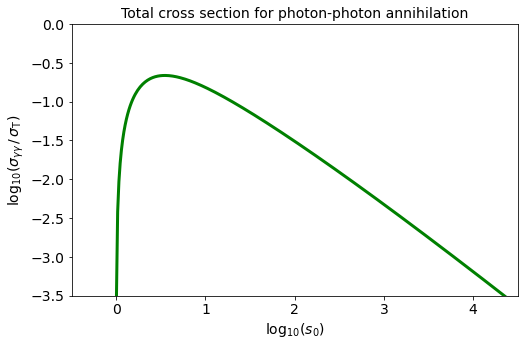

In [9]:
# Plotting the cross section

Er = restEnergy('electron')

plt.figure(figsize=(8,5))
plt.plot(np.log10(Eg*arrEph/Er/Er), np.log10(arrCS/thomsonCrossSection('electron')), lw=3, c="green")
plt.xlabel(r"$\log_{10} (s_0)$", fontsize=14)
plt.ylabel(r"$\log_{10} (\sigma_{\gamma \gamma}\,/\,\sigma_{\rm T})$", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-3.5,0)
plt.xlim(-0.5,4.5)
plt.title("Total cross section for photon-photon annihilation", fontsize=14)
plt.show()

In [10]:
nOpticalDepth = 10

def getNodesGL(points):
    return np.polynomial.legendre.leggauss(points) 

In [11]:
def opticalDepth(arrPhotonEnergy:np.array, 
                 arrPhotonDensity:np.array,
                 sourceSize:float, 
                 incidentPhotonEnergy:float, 
                 pairParticle:str='electron'):
    
    Eg = incidentPhotonEnergy
    Er = restEnergy(pairParticle)
    arrEph, arrNph = arrPhotonEnergy, arrPhotonDensity     
        
    s = float(Eg*arrEph[-1]/Er/Er)
    
    if s < 1:
        return 0
    
    Ethr = Er*Er/Eg
    arrNph = np.delete(arrNph, arrEph <= Ethr)
    arrEph = np.delete(arrEph, arrEph <= Ethr)
    
    if len(arrEph) == 0:
        return 0
    
    arrEmin, arrEmax = getSubArrays(arrEph)
    #---------------------------------------------------------------------
    # Getting the specific emissivity
    # partialEmissivity[i] = Emissivity between arrEmin[i], arrEmax[i]
    #---------------------------------------------------------------------
    partialOpticalDepth = np.empty_like(arrEmin)

    arrXgl, arrWgl = getNodesGL(nOpticalDepth)
    for i in range(len(arrEmin)):
        #-----------------------------------------------------------------
        # arrE = [arrEmin[i]:arrEmax[i]]
        # arrN = N(arrE)
        # arrP = single particle power for arrE
        #-----------------------------------------------------------------
        arrE_ = 0.5*(arrEmax[i]-arrEmin[i])*arrXgl + 0.5*\
          (arrEmax[i]+arrEmin[i])
        arrN_ = np.interp(arrE_,arrEph,arrNph)        
        arrCS_ = np.empty_like(arrE_)
        for k, Eph_ in enumerate(arrE_):
            arrCS_ = absorptionCrossSection(pairParticle=pairParticle,
                                            gammaRayEnergy=incidentPhotonEnergy,
                                            targetPhotonEnergy=Eph_)
            
        partialOpticalDepth[i] = 0.5*(arrEmax[i]-arrEmin[i])*\
            sum(arrWgl*arrN_*arrCS_)
    return sourceSize*partialOpticalDepth.sum()

**Example**: A photon of energy $1\,{\rm GeV}$ travels through the inner accretion disk of the active galactic nucleus Arkelian 120. The number density of the inner disk is $n = 10^{16}\,{\rm cm^{-3}}$, and we assume that the thickness of the region is $z = 2.25\times10^{16}\,{\rm cm}$ ($1000\,r_{\rm g}$ for a black hole with $M_{\rm BH} = 1.5\times 10^{8}\,M_{\odot}$), and plasma is composed of fully ionized hydrogen. Calculate the probability that the photon completely traverses the disk considering creation of electron-positron pairs in the electrostatic field of the plasma nuclei. If the photon is absorbed, at what typical distance is absorption expected to occur?

In [12]:
# Parameters of the disk

z = 2.25e16
n = 1e16

# Cross section

sigma = absorptionCrossSection(pairParticle='electron', 
                               gammaRayEnergy=1e9 *ev2erg, 
                               channel='electrostatic annihilation', 
                               nucleiType='naked', 
                               atomicNumber=1)

# Mean free path of the photon in the disk

mfp = 1/sigma/n

# Probability of absorption

prob = exp(-z/mfp)
print(f"The probability that the photon passes completely through the disk is {prob:0.1f}")

The probability that the photon passes completely through the disk is 0.0


In [13]:
print(f"The photon is absorbed in the Coulombian field when it travels a typical distance of {mfp:0.2e} cm")

The photon is absorbed in the Coulombian field when it travels a typical distance of 7.72e+08 cm


**Example**: Calculate the mean free path of a photon with $E=10\,{\rm TeV}$  in the cosmic microwave background.

If we assume that the CMB can be modeled as monochromatic radiation from a black body:

$$\langle E_{\rm ph} \rangle = 2.7 \kappa_{\rm B}T_{\rm CMB} = 2.3\times 10^{-10}\left(\frac{T_{\rm CMB}}{1\,{\rm K}} \right)\,{\rm MeV}$$

Then

$$\langle E_{\rm ph} \rangle \approx 6.3\times 10^{-4}\,{\rm eV}$$

In [14]:
# Parameters of the photons

Tcmb = 2.725
Ecmb = 2.7*boltzmannConstant*Tcmb
Eg = 1e1 *1e12 *ev2erg


# Cross section

sigma = absorptionCrossSection(pairParticle='electron', 
                               gammaRayEnergy=Eg, 
                               channel='photon-photon annihilation', 
                               targetPhotonEnergy=Ecmb, 
                               verbose=True)

The kinematic threshold for producing pairs is not reached


We see that the monochromatic approach fails. Photons with $E_{\gamma} = 10\,{\rm TeV}$ require more energetic targets to be absorbed.

In [15]:
Er = restEnergy('electron')
Ethr = Er*Er/Eg
print(f"The threshold energy for CMB photons to annihilate with the photon of 10 TeV is {Ethr*erg2ev:0.2e} eV")

The threshold energy for CMB photons to annihilate with the photon of 10 TeV is 2.61e-02 eV


$$\lambda_{\gamma \gamma}^{-1}(E_{\gamma}) = \int_{E_{\rm thr}(E_{\gamma})}^{\infty} {\rm d}E_{\rm ph} \sigma_{\gamma \gamma}( E_{\gamma}, E_{\rm ph})\, n_{\rm ph}(E_{\rm ph})$$

In [16]:
Epeak = 1.59*boltzmannConstant*Tcmb
fraccEphmin = Ethr/Epeak
fraccEphmax = 1e2 *fraccEphmin
EphGrid = 100

arrEph, arrNph, Uph = blackBody(gasTemperature=Tcmb, EphGrid=EphGrid, fraccEphmin=fraccEphmin, fraccEphmax=fraccEphmax)

In [17]:
nodes = 10

arrEmin, arrEmax = getSubArrays(arrEph)
partialIntegral = np.empty_like(arrEmin)
arrXgl, arrWgl = getNodesGL(nodes)

for i in range(len(arrEmin)):
    arrE_ = 0.5*(arrEmax[i]-arrEmin[i])*arrXgl + 0.5*\
      (arrEmax[i]+arrEmin[i])    
    arrN_ = np.interp(arrE_,arrEph,arrNph)        
    arrCS_ = np.empty_like(arrE_)
    for k, Eph_ in enumerate(arrE_):
        arrCS_ = absorptionCrossSection(pairParticle='electron',
                                        gammaRayEnergy=Eg,
                                        channel='photon-photon annihilation',
                                        targetPhotonEnergy=Eph_)
    partialIntegral[i] = 0.5*(arrEmax[i]-arrEmin[i])*sum(arrWgl*arrN_*arrCS_)  
    
mfp = 1/partialIntegral.sum()

print(f"The mean free path of the photon of 10 TeV in the CMB is {mfp/pc2cm/1e9:0.2e} Gpc")

The mean free path of the photon of 10 TeV in the CMB is 6.09e+42 Gpc


We see that the CMB is transparent to photons of $E_{\gamma} = 10\,{\rm TeV}$.

**Example**: Consider a star of effective temperature $T_* = 40\,000\,{\rm K}$ and radius $R_* = 15\,R_{\odot}$. Gamma rays are emitted at a distance $r$ from the center of the star. Calculate, as a function of $r$, the optical depth of the radiation field of the star for a photon with $E_{\gamma} = 100\,{\rm GeV}$. To do this, we assume the radiation field as isotropic.


By conservation of the flux of the radiation field:

$$ n_{\rm ph}(E_{\rm ph}, r) = \left(\frac{R_{*}}{r}\right)^2 n_{\rm ph}(E_{\rm ph}, R_{*}) = \left(\frac{R_{*}}{r}\right)^2 n_{\rm BB}(E_{\rm ph}, T_*)\left(\frac{R_{*}}{r}\right)^2 n_{\rm BB}(E_{\rm ph}, T_*)\qquad [{\rm erg^{-1}\,cm^{-3}}]$$

where $n_{\rm BB}(E_{\rm ph}, T_{*})$ corresponds to the energy density at the surface of the blackbody

$$\tau_{\gamma \gamma}(E_{\gamma}, r) = \int_{r}^{\infty}{\rm d}r \int_{E_{\rm thr}(E_{\gamma})}^{\infty}{\rm d}E_{\rm ph}\, n_{\rm ph}(E_{\rm ph}, r)\, \sigma_{\gamma \gamma}(E_{\gamma}, E_{\rm ph})$$

$$\tau_{\gamma \gamma}(E_{\gamma}, r) = \int_{r}^{\infty}{\rm d}r\, \left(\frac{R_{*}}{r}\right)^2 \int_{E_{\rm thr}(E_{\gamma})}^{\infty}{\rm d}E_{\rm ph}\,  n_{\rm BB}(E_{\rm ph}, T_*)\, \sigma_{\gamma \gamma}(E_{\gamma}, E_{\rm ph})$$

$$ \tau_{\gamma \gamma}(E_{\gamma}, r) = \int_{r}^{\infty}{\rm d}r\, \left(\frac{R_{*}}{r}\right)^2 \lambda_{\gamma \gamma}^{-1}(E_{\gamma})$$

$$ \tau_{\gamma \gamma}(E_{\gamma}, r) = \frac{R_{*}^2}{r\lambda_{\gamma \gamma}(E_{\gamma})} $$

where $\lambda_{\gamma \gamma}(E_{\gamma})$ is the mean free path of the photon with energy $E_{\gamma}$ in a radiation field of a blackbody at temperature $T_*$.

In [18]:
Rstar = 15*solarRadius
Tstar = 4e4
Eg = 1e1 *1e12 *ev2erg
Er = restEnergy('electron')

rmin = Rstar
rmax = 1e2 * rmin
rGrid = 1000
arrR = np.logspace(np.log10(rmin), np.log10(rmax), rGrid)

Ethr = Er*Er/Eg
Epeak = 1.59*boltzmannConstant*Tstar
Ephmin = Ethr
Ephmax = max(Ethr,Epeak)*1000
fEphmin = Ephmin/Epeak
fEphmax = Ephmax/Epeak
EphGrid = 1000
arrEph, arrNph, Uph = blackBody(gasTemperature=Tstar, EphGrid=EphGrid, fraccEphmin=fEphmin, fraccEphmax=fEphmax)

In [19]:
nodes = 10

arrEmin, arrEmax = getSubArrays(arrEph)
partialIntegral = np.empty_like(arrEmin)
arrXgl, arrWgl = getNodesGL(nodes)

for i in range(len(arrEmin)):
    arrE_ = 0.5*(arrEmax[i]-arrEmin[i])*arrXgl + 0.5*\
      (arrEmax[i]+arrEmin[i])    
    arrN_ = np.interp(arrE_,arrEph,arrNph)        
    arrCS_ = np.empty_like(arrE_)
    for k, Eph_ in enumerate(arrE_):
        arrCS_ = absorptionCrossSection(pairParticle='electron',
                                        gammaRayEnergy=Eg,
                                        channel='photon-photon annihilation',
                                        targetPhotonEnergy=Eph_)
    partialIntegral[i] = 0.5*(arrEmax[i]-arrEmin[i])*sum(arrWgl*arrN_*arrCS_)  
    
mfp = 1/partialIntegral.sum()
arrTau = Rstar**2 /mfp/arrR

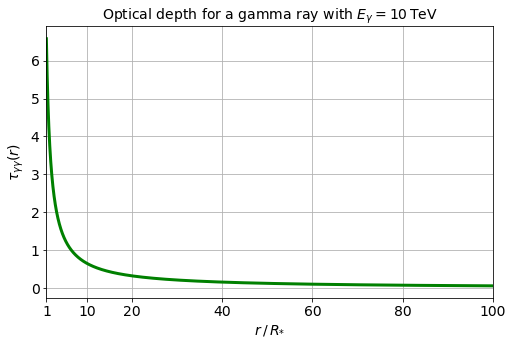

In [20]:
# Plotting the cross section


plt.figure(figsize=(8,5))
#plt.plot(np.log10(arrR/Rstar), np.log10(arrTau), lw=3, c="green")
plt.plot((arrR/Rstar), (arrTau), lw=3, c="green")
plt.xlabel(r"$r\,/\,R_{*}$", fontsize=14)
plt.ylabel(r"$\tau_{\gamma \gamma}(r)$", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.ylim(-3.5,0)
plt.xlim(1,100)
plt.xticks([1,10,20,40,60,80,100])
plt.title(r"Optical depth for a gamma ray with $E_{\gamma}=10\,{\rm TeV}$", fontsize=14)
plt.show()

It can be better visualized with a heat map

In [21]:
# Input parameters

Egmin = 1e9 *ev2erg
Egmax = 1e15 *ev2erg
EgGrid = 100
arrEph = np.logspace(np.log10(Egmin), np.log10(Egmax), EgGrid)

Rstar = 15*solarRadius
rmin = Rstar
rmax = 1e4 * rmin
rGrid = 100
arrR = np.logspace(np.log10(rmin), np.log10(rmax), rGrid)

In [25]:
# Mean free path for a gamma ray in a radiation field of a blackbody

def mfp_blackbody(gasTemperature:float, 
                  photonEnergy:float,
                  pairParticle:str='electron',                   
                  nodesGL:int=10, 
                  photonGrid:int=1000, 
                  fraccEphmax=1000):
    
    nodesGL = 10
    Er = restEnergy(pairParticle)
    Eg = photonEnergy
    T = gasTemperature
    kb = boltzmannConstant
    Ethr = Er*Er/Eg
    
    Epeak = 1.59*kb*T
    Ephmin, Ephmax = Ethr, max(Ethr,Epeak)*fraccEphmax    
    fEphmin, fEphmax = Ephmin/Epeak, Ephmax/Epeak         
    arrEph, arrNph, Uph = blackBody(gasTemperature=T, EphGrid=photonGrid, fraccEphmin=fEphmin, fraccEphmax=fEphmax)
    
    arrEmin, arrEmax = getSubArrays(arrEph)
    partialIntegral = np.empty_like(arrEmin)
    arrXgl, arrWgl = getNodesGL(nodesGL)
    for i in range(len(arrEmin)):
        arrE_ = 0.5*(arrEmax[i]-arrEmin[i])*arrXgl + 0.5*\
          (arrEmax[i]+arrEmin[i])    
        arrN_ = np.interp(arrE_,arrEph,arrNph)        
        arrCS_ = np.empty_like(arrE_)
        for k, Eph_ in enumerate(arrE_):
            arrCS_ = absorptionCrossSection(pairParticle='electron',
                                            gammaRayEnergy=Eg,
                                            channel='photon-photon annihilation',
                                            targetPhotonEnergy=Eph_)
        partialIntegral[i] = 0.5*(arrEmax[i]-arrEmin[i])*sum(arrWgl*arrN_*arrCS_)      

    return 1/partialIntegral.sum()

In [26]:
# Optical depth for a gamma ray in a radiation field of a star

def tau_star(distance:float,
             starRadius:float,
             starTemperature:float, 
             photonEnergy:float,
             pairParticle:str='electron',                   
             nodesGL:int=10, 
             photonGrid:int=1000, 
             fraccEphmax=1000):
    
    mfp = mfp_blackbody(starTemperature, 
                        photonEnergy,
                        pairParticle,                   
                        nodesGL, 
                        photonGrid, 
                        fraccEphmax)

    return starRadius**2 /mfp/distance

In [27]:
# Meshs

EphMesh, rMesh = np.meshgrid(arrEph, arrR)
TauMesh = np.empty_like(EphMesh)
for i in range(EgGrid):
    for j in range(rGrid):
        TauMesh[i][j] = tau_star(distance=rMesh[i][j],
                                 starRadius=Rstar,
                                 starTemperature=Tstar,
                                 photonEnergy=EphMesh[i][j],
                                 photonGrid=EgGrid)            

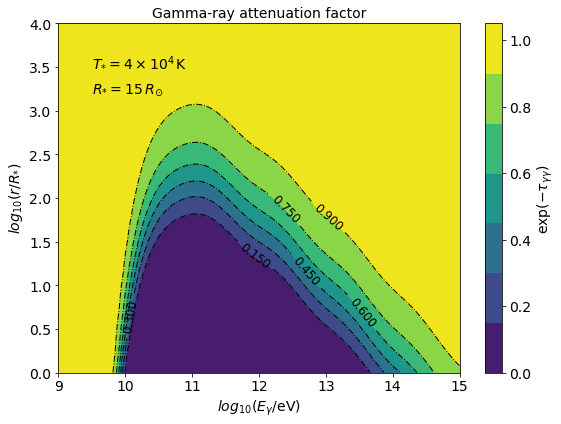

In [28]:
plt.figure(figsize=(8,6))

img = plt.contourf(np.log10(EphMesh*erg2ev), np.log10(rMesh/Rstar), np.exp(-TauMesh), vmin=0, vmax=1, cmap='viridis')
plt.xlabel(r'$log_{10}(E_{\gamma}/{\rm eV})$', fontsize=14)
plt.ylabel(r'$log_{10}(r/R_{*})$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar = plt.colorbar(ticks=[0,0.2,0.4,0.6,0.8,1])
tick_font_size = 14
cbar.ax.tick_params(labelsize=tick_font_size)
cbar.set_label(label=r'$\exp(-\tau_{\gamma \gamma})$', fontsize=14)
plt.title(r"Gamma-ray attenuation factor", fontsize=14)
plt.annotate(r"$T_{*} = 4\times 10^{4}\,{\rm K}$", (9.5,3.5), fontsize=14)
plt.annotate(r"$R_{*} = 15\,R_{\odot}$", (9.5,3.2), fontsize=14)
plt.tight_layout()

CS = plt.contour(np.log10(EphMesh*erg2ev), np.log10(rMesh/Rstar), np.exp(-TauMesh), 6, colors='k', linestyles='dashdot', linewidths=1)
plt.clabel(CS, inline=True, fontsize=12)

plt.show()

We see that the attenuated radiation have energies in the range $E_{\gamma}=10\,{\rm GeV} - 100\,{\rm TeV}$, and it is produced below $r < 100\,R_{*}$.

References:

- Introduction to Relativistic Astrophysics, Gustavo E. Romero (2018)
- PhD. Thesis, Gabriela S. Vila (2012)
- Introduction to Black Hole Astrophysics, Gustavo E. Romero & Gabriela S. Vila (2014)